In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV,KFold,train_test_split
from sklearn.datasets import load_diabetes
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
from graph_utils import plot_multiple,plot_xy

%matplotlib inline


# DATA PREPARATION

In [2]:
file_path = None

if not(file_path):
    df = load_diabetes()
    X = df["data"]
    y = df["target"]
else:
    df = pd.read_csv(file_path,keep_default_na=False,na_values="").drop("Unnamed: 0",axis=1)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=31)
print('Train set size',X_train.shape[0],'Test set size',X_test.shape[0])

Train set size 88 Test set size 354


In [4]:
def sta(df,df_ref):
    return (df - df_ref.mean())/df_ref.std(ddof=1)

def decenter(df,df_ref):
    return (df * df_ref.std(ddof=1)) + df_ref.mean()

X_train_t = np.transpose(X_train)
X_test_t = np.transpose(X_test)

for i,col in enumerate(X_train_t) :
    X_train_t[i] = center(col, col)
    X_test_t[i] = center(X_test_t[i], col)
X_train_modified = np.transpose(X_train_t)
X_test_modified = np.transpose(X_test_t)

y_train_modified = center(y_train,y_train)
y_test_modified = center(y_test,y_train)

# REGRESSIONS

In [5]:
def train_model(model,X_train,y_train,X_test,y_test,GS=False):
    reg = model.fit(np.array(X_train), y_train)
    if GS:
        print(model.best_params_)

    for i in range(X_test.shape[0]):
        y_hat_test = reg.predict(np.array(X_test))
        y_hat_train = reg.predict(np.array(X_train))
    return y_hat_test,y_hat_train

def run_models(X_train,y_train,X_test,y_test,models,GS=False,y_hat=None,y_hat_train=None):
    if not(y_hat):
        y_hat = {}
    if not(y_hat_train):
        y_hat_train = {}
    for model_name in models.keys():
        y_hat[model_name],y_hat_train[model_name] = train_model(models[model_name],X_train,y_train,X_test,y_test,GS=GS)  
    return y_hat,y_hat_train

def compute_mse(y_test,y_hat,dict_mse=None):
    if not(dict_mse):
        dict_mse = {}
    for model_name in models.keys():
        dict_mse[model_name] = r2_score(np.array(y_test).reshape(-1,1),np.array(y_hat[model_name]))
        
    return dict_mse

In [6]:
models = {"Linear":LinearRegression(),
          "Ridge":Ridge(),
          "Lasso":Lasso(),
          "Elastic Net":ElasticNet(),
          "LGBM":LGBMRegressor(n_estimators=1000),
          "MLP":MLPRegressor()}

y_hat,y_hat_train = run_models(X_train,y_train,X_test,y_test,models)
dict_mse=compute_mse(y_test,y_hat)
dict_mse_train=compute_mse(y_train,y_hat_train)

y_hat_modified,y_hat_modified_train = run_models(X_train_modified,y_train_modified,X_test_modified,y_test_modified,models)
for model_name in models.keys():
    y_hat_modified[model_name] = decenter(y_hat_modified[model_name],y_train)
    y_hat_modified_train[model_name] = decenter(y_hat_modified_train[model_name],y_train)
dict_mse_modified = compute_mse(y_test,y_hat_modified)
dict_mse_modified_train = compute_mse(y_train,y_hat_modified_train)



/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [7]:
dict_mse_train

{'Linear': 0.42629601568309805,
 'Ridge': 0.42438088592203516,
 'Lasso': 0.42008327102471055,
 'Elastic Net': 0.39419401551719746,
 'LGBM': 0.9766319142418848,
 'MLP': -4.328605168421592}

In [8]:
dict_mse

{'Linear': -0.09474725620573543,
 'Ridge': -0.09664522335807901,
 'Lasso': -0.09839285660368424,
 'Elastic Net': -0.10591069118991348,
 'LGBM': 0.05255331460334611,
 'MLP': -3.339404655236131}

MLP


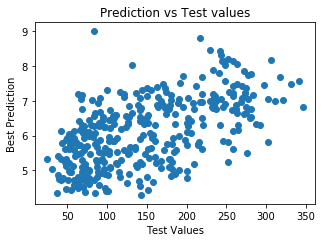

In [9]:
best_model = min(dict_mse, key=dict_mse.get)
print(best_model)

Series = [y_test,y_hat[best_model]]
xlabel = "Test Values"
ylabel = "Best Prediction"
title = "Prediction vs Test values"
plot_xy(Series, xlabel, ylabel, title,kind="Scatter")

In [10]:
dict_mse_modified_train

{'Linear': 0.42629601568309805,
 'Ridge': 0.42438088592203516,
 'Lasso': 0.0,
 'Elastic Net': 0.0361915403982036,
 'LGBM': 0.9766319146657619,
 'MLP': 0.8272101885049479}

In [11]:
dict_mse_modified

{'Linear': -0.09474725620573543,
 'Ridge': -0.09664522335807924,
 'Lasso': -0.13849913663084612,
 'Elastic Net': -0.13664035975594446,
 'LGBM': 0.05255332044045835,
 'MLP': -0.004561465409088861}

Lasso


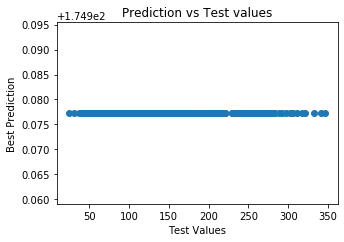

In [12]:
best_model = min(dict_mse_modified, key=dict_mse_modified.get)
print(best_model)

Series = [y_test,y_hat_modified[best_model]]
xlabel = "Test Values"
ylabel = "Best Prediction"
title = "Prediction vs Test values"
plot_xy(Series, xlabel, ylabel, title,kind="Scatter")

# GridSearch

In [13]:

param_grid = {}

# MLP

In [14]:
param_grid["MLP"] = {
    'hidden_layer_sizes':[(i,) for i in range(100,1000,100)],
    'activation':['identity', 'logistic', 'tanh', 'relu'],
    'solver':["adam","lbfgs"],
    'learning_rate':["adaptive"],
    'max_iter':[1000],
    'early_stopping':[True]
    }
gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
MLP_GS = GridSearchCV(estimator=MLPRegressor(), param_grid=param_grid["MLP"], cv=gkf,verbose=1)

## LGBM

In [15]:
param_grid["LGBM"] = {
    'boosting_type':["gbdt","rf"],
    'max_depth': [-1],
    'n_estimators':[1000],
    'subsample':[1],
    'colsample_bytree':[1],
    'reg_alpha':[0],
    'reg_lambda':[0],
    'num_leaves':[i for i in range(2,100)]
    }
gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
LGBM_GS = GridSearchCV(estimator=LGBMRegressor(), param_grid=param_grid["LGBM"], cv=gkf,verbose=1)

## Ridge

In [16]:
param_grid["Ridge"] = {
    'alpha':[i/10 for i in range(1,11)]
    }
gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
Ridge_GS = GridSearchCV(estimator=Ridge(), param_grid=param_grid["Ridge"], cv=gkf,verbose=1)

## Lasso

In [17]:
param_grid["Lasso"] = {
    'alpha':[i/10 for i in range(1,11)]
    }
gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
Lasso_GS = GridSearchCV(estimator=Lasso(), param_grid=param_grid["Lasso"], cv=gkf,verbose=1)

## ElasticNet

In [18]:
param_grid["ElasticNet"] = {
    'alpha':[i/10 for i in range(1,11)],
    'l1_ratio':[i/10 for i in range(1,11)]
    }
gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
ElasticNet_GS = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid["ElasticNet"], cv=gkf,verbose=0)

In [19]:
models = {"LGBM GS":LGBM_GS,"Ridge GS":Ridge_GS,"Lasso GS":Lasso_GS,"ElasticNet GS":ElasticNet_GS,'MLP GS':MLP_GS}




In [20]:
y_hat_modified, y_hat_modified_train = run_models(X_train_modified,
                                                  y_train_modified,
                                                  X_test_modified,
                                                  y_test_modified,
                                                  models,
                                                  GS=True,
                                                  y_hat=y_hat_modified,
                                                  y_hat_train=y_hat_modified_train)
for model_name in models.keys():
    y_hat_modified[model_name] = decenter(y_hat_modified[model_name],y_train)
    y_hat_modified_train[model_name] = decenter(y_hat_modified_train[model_name],y_train)
dict_mse_modified=compute_mse(y_test,y_hat_modified,dict_mse=dict_mse_modified)
dict_mse_modified_train=compute_mse(y_train,y_hat_modified_train,dict_mse=dict_mse_modified_train)

Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .



/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selecti

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selecti

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selecti

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selecti

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selecti

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selecti

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selecti

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selecti

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /Users/runner/runners/2.160.1/work/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .


  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selecti

{'boosting_type': 'gbdt', 'colsample_bytree': 1, 'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 2, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 1.0}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


{'alpha': 0.1}
{'alpha': 0.2, 'l1_ratio': 0.3}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.1min finished


{'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (900,), 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'adam'}


# RESULTS

In [21]:
dict_mse_modified_train

{'Linear': 0.42629601568309805,
 'Ridge': 0.42438088592203516,
 'Lasso': 0.0,
 'Elastic Net': 0.0361915403982036,
 'LGBM': 0.9766319146657619,
 'MLP': 0.8272101885049479,
 'LGBM GS': 0.7361584462078867,
 'Ridge GS': 0.42438088592203516,
 'Lasso GS': 0.3840910323279163,
 'ElasticNet GS': 0.39196285204417913,
 'MLP GS': 0.4184132693120505}

In [22]:
dict_mse_modified

{'Linear': -0.09474725620573543,
 'Ridge': -0.09664522335807924,
 'Lasso': -0.13849913663084612,
 'Elastic Net': -0.13664035975594446,
 'LGBM': 0.05255332044045835,
 'MLP': -0.004561465409088861,
 'LGBM GS': 0.2185165562511986,
 'Ridge GS': -0.09664522335807924,
 'Lasso GS': -0.10781851104942453,
 'ElasticNet GS': -0.10623427953835174,
 'MLP GS': -0.08185556606839728}

LGBM GS


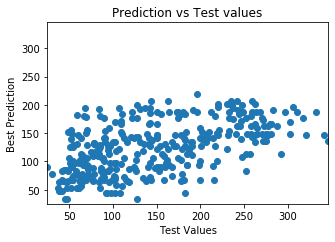

In [23]:
best_model = max(dict_mse_modified, key=dict_mse_modified.get)
print(best_model)
Series = [y_test,y_hat_modified[best_model]]
xlabel = "Test Values"
ylabel = "Best Prediction"
title = "Prediction vs Test values"
plot_xy(Series, xlabel, ylabel, title,kind="Scatter",same_xy=True)